In [1]:
#Need to use Neural Network since its a complex non-linear relationship: Multilayer Perceptron (MLP).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import sklearn as sk
import random




In [3]:


from sklearn.cluster import KMeans


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler




In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow import keras

import joblib

In [6]:
#import databse

# df = pd.read_csv('../data/raw/Elite_Sports_Cars_in_Data.csv')
df = pd.read_csv('../data/raw/5000_car_dataset_TRANSMISSION_FIXED_FINAL.csv')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brand               5000 non-null   object 
 1   Model               5000 non-null   object 
 2   Year                5000 non-null   int64  
 3   Horsepower          5000 non-null   int64  
 4   Engine_Size         5000 non-null   float64
 5   Weight              5000 non-null   int64  
 6   Torque              5000 non-null   int64  
 7   Acceleration_0_100  5000 non-null   float64
 8   Power_Weight        5000 non-null   float64
 9   Torque_Weight       5000 non-null   float64
 10  Drivetrain          5000 non-null   object 
 11  Transmission        5000 non-null   object 
dtypes: float64(4), int64(4), object(4)
memory usage: 468.9+ KB


In [8]:
df["Power_Weight"] = df["Horsepower"] / df["Weight"]
df["Torque_Weight"] = df["Torque"] / df["Weight"]
# df["Hp_liter"] = df["Horsepower"] / df["Engine_Size"]

# df["Car_Age"] = 2025 - df["Year"] -> turned to be redundant, introduce noise
# df["Mileage_Per_Year"] = df["Mileage"] / df["Car_Age"].replace(0, 1) -> turned to be redundant, introduce noise
# df["Speed_Efficiency"] = df["Top_Speed"] / df["Horsepower"] -> turned to be redundant, introduce noise

# One-hot encode categorical features we need.
df_encoded = pd.get_dummies(
    df, 
    columns=['Drivetrain', 'Transmission'],
    drop_first=True,
    dtype=int
)


In [9]:
#df encoded shoudl not have drivetrain and transmission, but instead have the new ones 
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brand               5000 non-null   object 
 1   Model               5000 non-null   object 
 2   Year                5000 non-null   int64  
 3   Horsepower          5000 non-null   int64  
 4   Engine_Size         5000 non-null   float64
 5   Weight              5000 non-null   int64  
 6   Torque              5000 non-null   int64  
 7   Acceleration_0_100  5000 non-null   float64
 8   Power_Weight        5000 non-null   float64
 9   Torque_Weight       5000 non-null   float64
 10  Drivetrain_RWD      5000 non-null   int64  
 11  Transmission_DCT    5000 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 468.9+ KB


In [10]:
# 3.1 Select features + target

Numerical_features = [
    "Year", 
    "Horsepower", 
    "Engine_Size", 
    "Torque",
    "Power_Weight", 
    "Torque_Weight",
    "Weight",
    # "Hp_liter"
    #adding transmission, drivtrain, fuel type, modification to see its effect. DONe
    #need encoding and one hot as well as droping redundancies for colinearity   
]

Binary_features = [
    # 'Drivetrain_AWD', # zero because of drop first coloumn.
    'Drivetrain_RWD', # 1
    'Transmission_DCT',# 1
    # 'Transmission_Auto' # zero because of drop first coloumn.
]


#combine the feature
features = Numerical_features + Binary_features


X = df_encoded[features].values
y = df_encoded["Acceleration_0_100"].values

print("Columns in df_encoded:")
print(df_encoded.columns.tolist())
print("\n")
print("Chosen Features:")
print(features)



Columns in df_encoded:
['Brand', 'Model', 'Year', 'Horsepower', 'Engine_Size', 'Weight', 'Torque', 'Acceleration_0_100', 'Power_Weight', 'Torque_Weight', 'Drivetrain_RWD', 'Transmission_DCT']


Chosen Features:
['Year', 'Horsepower', 'Engine_Size', 'Torque', 'Power_Weight', 'Torque_Weight', 'Weight', 'Drivetrain_RWD', 'Transmission_DCT']


In [11]:
# 4. Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, 
    random_state=42
)


In [12]:
#set up separation for scaling issue
#get index of the numerical and binary features
numerical_indexes = [features.index(f) for f in Numerical_features]
binary_indexes = [features.index(f) for f in Binary_features]

# separate the training set into numeric and binary so we can only scale the numeric and then add it back
X_train_numerical= X_train[:,numerical_indexes]
X_train_binary = X_train[:,binary_indexes]

X_test_numerical= X_test[:,numerical_indexes]
X_test_binary = X_test[:,binary_indexes]


In [13]:
# 5. Scaling / normalaization so no value dominates any other value. 
# -----------------------------

scaler = StandardScaler()

# now we take the separeted numerics and scale them

X_train_scaled_numerical = scaler.fit_transform(X_train_numerical)
X_test_scaled_numercial  = scaler.transform(X_test_numerical)

# Now we take the scalred numerics and concatinate them with the binary to make the main train and test set.

X_train = np.concatenate([X_train_scaled_numerical,X_train_binary], axis = 1 )

X_test = np.concatenate([X_test_scaled_numercial,X_test_binary], axis = 1 )



In [14]:
# 6. Build Neural Network
# -----------------------------
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    
    Dense(64, activation='relu'), # changed to 128 since we have more features now.
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(32, activation='relu'),

    Dense(1)  # output layer for regression
])
#added momentum since we kept detecting oscillation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.00005,
                                    momentum=0.9,
                                    clipnorm=1.0),
    loss='mse',
    metrics=['mae']
)


2025-12-02 15:44:53.985566: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-12-02 15:44:53.985614: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-12-02 15:44:53.985620: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-12-02 15:44:53.985641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-02 15:44:53.985653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [16]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    shuffle=True
)


Epoch 1/200


2025-12-02 15:44:58.074238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.2923 - mae: 3.0765 - val_loss: 9.5910 - val_mae: 2.9915
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7372 - mae: 2.9945 - val_loss: 8.9622 - val_mae: 2.8940
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.0983 - mae: 2.8945 - val_loss: 8.3472 - val_mae: 2.7939
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4624 - mae: 2.7893 - val_loss: 7.7568 - val_mae: 2.6927
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9630 - mae: 2.7022 - val_loss: 7.1914 - val_mae: 2.5905
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2677 - mae: 2.5749 - val_loss: 6.6509 - val_mae: 2.4871
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7548 - mae: 2.4758 - val_loss: 6.1356 - val_mae: 2.3826
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2575 - mae: 2.3744 - val_loss: 5.6452 - val_mae: 2.2768
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7093 - mae: 2

In [17]:
# Save model for live prediction and later evaluation.

model.save('../models/nn_zero_to_sixty.keras')


joblib.dump(features, '../models/feature_names.pkl')


joblib.dump(scaler, '../models/nn_scaler.pkl')



# Save feature info for selective scaling
feature_info = {
    'numeric_features': Numerical_features,
    'binary_features': Binary_features,
    'numeric_indices': [features.index(f) for f in Numerical_features],
    'binary_indices': [features.index(f) for f in Binary_features],
    'total_features': len(features)
}
joblib.dump(feature_info, '../models/feature_info.pkl')



['../models/feature_info.pkl']

In [18]:
# correlation with target
print("Correlation with Acceleration_0_100:")


# Numeric features
for feat in Numerical_features:
    corr = df_encoded[feat].corr(df_encoded['Acceleration_0_100'])
    print(f"{feat:25s}: {corr:+.4f}")

# Binary features
for feat in Binary_features:
    corr = df_encoded[feat].corr(df_encoded['Acceleration_0_100'])
    print(f"{feat:25s}: {corr:+.4f}")

Correlation with Acceleration_0_100:
Year                     : -0.2972
Horsepower               : -0.6023
Engine_Size              : -0.0011
Torque                   : -0.5895
Power_Weight             : -0.7663
Torque_Weight            : -0.7513
Weight                   : +0.6614
Drivetrain_RWD           : +0.0100
Transmission_DCT         : -0.6011


In [19]:
#seems like they are being scaled, and that is why we are getting the same results as the 7-feature training model. 



In [20]:
model = keras.models.load_model(
    '../models/nn_zero_to_sixty.keras',
    compile=True
)

In [22]:
model.compile(optimizer='rmsprop', loss='mse')

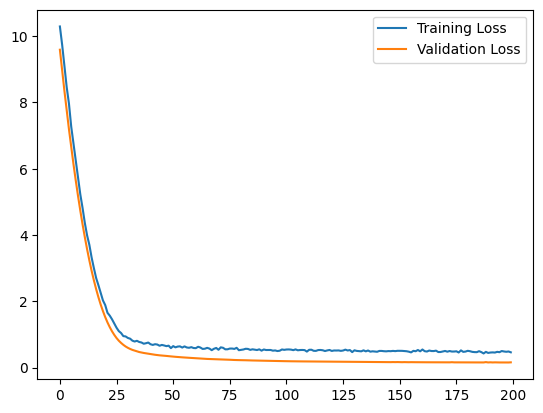

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [28]:

test_results = model.evaluate(X_test, y_test, verbose=1)

test_loss = test_results[0]
test_mae = test_results[1] 

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {np.sqrt(test_loss):.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1601 - mae: 0.3139
Test Loss (MSE): 0.1601
Test MAE: 0.3139
Test RMSE: 0.4001


In [29]:
#run using: Year', 'Horsepower', 'Weight', 'Torque', 'Power_Weight', 'Torque_Weight', 'Transmission_DCT', 'Transmission_Auto'], 
#with drop first for encoded. 

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1156 - mae: 0.2732
# Test Loss (MSE): 0.1156
# Test MAE: 0.2732
# Test RMSE: 0.3400

#run using: Year', 'Horsepower', 'Weight', 'Torque', 'Power_Weight', 'Torque_Weight', 'Transmission_DCT', 'Transmission_Auto'], 
#with drop first for encoded. 

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1277 - mae: 0.2835
# Test Loss (MSE): 0.1277
# Test MAE: 0.2835
# Test RMSE: 0.3574


#run with ['Year', 'Horsepower', 'Weight', 'Torque', 'Power_Weight', 'Torque_Weight', 'Drivetrain_RWD', 'Transmission_DCT'],
#   optimizer=keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9),
#  epochs=200,
#     batch_size=128,
#     validation_split=0.2,
#     callbacks=[early_stop],
#     shuffle=True
# df_encoded = pd.get_dummies(
#     df, 
#     columns=['Drivetrain', 'Transmission'],
#     drop_first=True,
#     dtype=int
# )

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1447 - mae: 0.3001
# Test Loss (MSE): 0.1447
# Test MAE: 0.3001
# Test RMSE: 0.3804
# no snpike in graph.


# was run with leanring rate reudction with gds, and using  adam  iwth the leanring rate wboth gave bad results. compared to what we had to this point



# again we ran it and had these results

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1406 - mae: 0.2965
# Test Loss (MSE): 0.1406
# Test MAE: 0.2965?
# Test RMSE: 0.3750


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1538 - mae: 0.3069
# Test Loss (MSE): 0.1538
# Test MAE: 0.3069
# Test RMSE: 0.3921


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1641 - mae: 0.3179
# Test Loss (MSE): 0.1641
# Test MAE: 0.3179
# Test RMSE: 0.4051


#run with ['Year', 'Horsepower', 'Weight', 'Torque', 'Power_Weight', 'Engine_size', 'Torque_Weight', 'Drivetrain_RWD', 'Transmission_DCT'],
#   optimizer=keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9),
#  epochs=200,
#     batch_size=128,
#     validation_split=0.2,
#     callbacks=[early_stop],
#     shuffle=True
# df_encoded = pd.get_dummies(
#     df, 
#     columns=['Drivetrain', 'Transmission'],
#     drop_first=True,
#     dtype=int
# )

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1425 - mae: 0.3056
# Test Loss (MSE): 0.1425
# Test MAE: 0.3056
# Test RMSE: 0.3776


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1374 - mae: 0.2912
# Test Loss (MSE): 0.1374
# Test MAE: 0.2912
# Test RMSE: 0.3707


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1624 - mae: 0.3194
# Test Loss (MSE): 0.1624
# Test MAE: 0.3194
# Test RMSE: 0.4029


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1385 - mae: 0.2991
# Test Loss (MSE): 0.1385
# Test MAE: 0.2991
# Test RMSE: 0.3721


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2327 - mae: 0.3677
# Test Loss (MSE): 0.2327
# Test MAE: 0.3677
# Test RMSE: 0.4824
# huge spike.
# Epoch 116/200
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9798 - mae: 0.6941 - val_loss: 0.2287 - val_mae: 0.3622
# Epoch 117/200
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.1816 - mae: 2.1937 - val_loss: 17.7747 - val_mae: 3.3657
# Epoch 118/200
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1049.5535 - mae: 19.8809 - val_loss: 83.2351 - val_mae: 7.3235
# Epoch 119/200
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 44.0157 - mae: 4.4439 - val_loss: 3.6105 - val_mae: 1.4323
# Epoch 120/200
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9601 - mae: 1.4718 - val_loss: 2.1139 - val_mae: 1.0881
# Epoch 121/200
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2827 - mae: 0.9040 - val_loss: 0.9825 - val_mae: 0.7630
# Epoch 122/200
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9574 - mae: 0.7930 - val_loss: 0.6646 - val_mae: 0.7119
# Epoch 123/200


#






# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1367 - mae: 0.2972
# Test Loss (MSE): 0.1367
# Test MAE: 0.2972
# Test RMSE: 0.3698


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1650 - mae: 0.3073
# Test Loss (MSE): 0.1650
# Test MAE: 0.3073
# Test RMSE: 0.4062


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1372 - mae: 0.2931
# Test Loss (MSE): 0.1372
# Test MAE: 0.2931
# Test RMSE: 0.3704

# "with weight."


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1601 - mae: 0.3139
# Test Loss (MSE): 0.1601
# Test MAE: 0.3139
# Test RMSE: 0.4001



# without weight
# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1792 - mae: 0.3104
# Test Loss (MSE): 0.1792
# Test MAE: 0.3104
# Test RMSE: 0.4233

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1582 - mae: 0.3091
# Test Loss (MSE): 0.1582
# Test MAE: 0.3091
# Test RMSE: 0.3978

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1409 - mae: 0.2953
# Test Loss (MSE): 0.1409
# Test MAE: 0.2953
# Test RMSE: 0.3754

# anomaly 
# Test Loss (MSE): 10.4148
# Test MAE: 3.1145
# Test RMSE: 3.2272?


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1601 - mae: 0.3139
# Test Loss (MSE): 0.1601
# Test MAE: 0.3139
# Test RMSE: 0.4001


# removing enginesize


# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1323 - mae: 0.2888
# Test Loss (MSE): 0.1323
# Test MAE: 0.2888
# Test RMSE: 0.3638

# 32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1249 - mae: 0.2825
# Test Loss (MSE): 0.1249
# Test MAE: 0.2825
# Test RMSE: 0.3535